In [8]:
import cv2
import numpy as np
import glob
import seaborn as sns
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [9]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('results_img/'+str(count_img)+'ed.jpg', edges)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 100 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [10]:
def divideImage(img,lung):
    results = []
    
    for i in range(2048// lung):
        results.append(img[(lung*i):(lung*(i+1))][:])

    return results

In [11]:
def create_PCA(image_arrays,components):
    
    x = image_arrays

    scaler.fit(x)
    x = scaler.transform(x)

    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(x)

    return principalComponents, pca

In [12]:
def use_PCA(image_arrays,pca):
    
    x = image_arrays

    x = scaler.transform(x)

    principalComponents = pca.transform(x)

    return principalComponents

In [13]:
## creazione array da immagine
def createNN(imgsWithClass):
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass[0]
    res = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        im.append(imgsWithClass[1][k])
        k += 1
        res.append(im)
    
    res = np.array(res)
    
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    
    
    return res
    #return kmeans, mlp, val_result

In [33]:
## creazione array da immagine
def createNN_2(imgsWithClass):
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass
    res = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        k += 1
        res.append(im)
    
    res = np.array(res)
    
    
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    
    
    return res
    #return kmeans, mlp, val_result

In [34]:
## data un'immagine creo l'array e fitto il modello 

def testNN(train_imgs):
    
    results=[]
    
    res = []
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        res.append(im)
    
    res = np.array(res)
    
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    cols = []
        
    for i in range(len(res[0])):
        cols.append('F'+str(i+1))


    df = pd.DataFrame(res ,columns = cols)
    results.append(model.predict(df[cols]))

    return results

In [16]:
def scale_image(img,scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)    

85
7514
0.011312217194570135


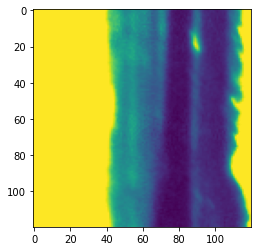

In [117]:
count_img = 0 
scelta = 120
threshold = 5
if scelta == 70:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
    contamination_N = 6/79.

if scelta == 100:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
    contamination_N = 6/107.
if scelta == 120:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'
    contamination_N = 6/126.

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/Dataset/SectionScarti/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'



scaler = StandardScaler() 

lunghezza_sezione_immagine = 120
border = 60
Nclusters = 10
reduction = 30
pca_components_number = 1000
#
#
pezziXimmagine = 2048 // lunghezza_sezione_immagine

results = []
img_results = []
list_paths = []

list_paths_scarti = glob.glob(pathScarti)
results += [1] * len(glob.glob(pathScarti)) * pezziXimmagine

temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathBuoni = temp

list_paths = glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine


#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine



for img_path in list_paths_scarti:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(img)
    #plt.show()
    img_results.append(img)
    
    
    
imgs_for_PCA = []
#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    cv2.imwrite('results_img/'+str(count_img)+'im.jpg', img)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    img_results += temp2
    imgs_for_PCA += temp2
    #j = 0
    #for im in temp2:
    cv2.imwrite('results_img/'+str(count_img)+'.jpg', temp)
    #j += 1
    i += 1
    count_img += 1
    
contamination_N = (len(list_paths_scarti)) / (len(img_results) )

print(len(list_paths_scarti))
print(len(img_results))

print(contamination_N)
    
plt.imshow(img_results[1])
plt.show()

In [118]:
## creazione PCA

temp = []



for img in imgs_for_PCA:
    temp.append(scale_image(img,reduction))
    
imgs_for_PCA2 = temp



    
array_PCA = np.array(imgs_for_PCA2)
array_PCA = array_PCA/255.



In [119]:
color_max = 0.6


array_PCA[array_PCA>=color_max]=1.


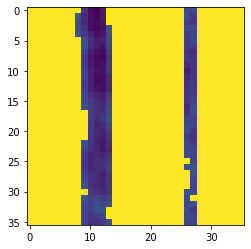

In [120]:
plt.imshow(array_PCA[5],interpolation='nearest')
plt.show()

In [121]:

array_PCA = createNN_2(array_PCA)


principalComponents, pca = create_PCA(array_PCA,pca_components_number)



In [122]:
temp = []

for img in img_results:
    temp.append(scale_image(img,reduction))
    

In [123]:
img_results = temp

In [124]:
train_images = np.array(img_results)
train_images = train_images/255.

In [125]:
train_images[train_images>=color_max]=1.



In [126]:
imgsWithClass = [train_images,results]


histo_t = createNN_2(imgsWithClass[0])

histo = use_PCA(histo_t,pca)

In [127]:
import pandas as pd

print(Nclusters)
cols = []
hist_2 = []
i = 0




for i in range(len(histo[0])):
    cols.append('F'+str(i+1))


df = pd.DataFrame(histo ,columns = cols)



10


In [128]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F991,F992,F993,F994,F995,F996,F997,F998,F999,F1000
0,-28.742978,24.840174,52.359204,82.881660,37.496368,-24.792271,-7.110198,-78.928480,18.224043,29.334092,...,-0.284136,-2.010670,-1.235442,-1.200263,-2.268898,-1.048901,0.175498,-1.075266,0.610765,0.374543
1,-27.039934,18.640291,50.255127,74.545396,29.241446,-28.670381,-13.495575,-88.148123,16.023396,34.402756,...,-0.740080,-1.321726,-0.699117,-0.000231,1.930295,-0.765299,-0.445114,-0.318612,3.444894,-1.418108
2,24.443897,32.218812,-12.408215,4.541448,1.651580,-8.845560,0.094182,-0.717329,-1.882955,-4.998336,...,-0.542853,0.216150,0.136922,0.393432,-0.044935,-0.007529,0.079926,-0.211227,-0.474449,0.117435
3,19.523484,29.516834,-14.898109,1.053854,12.972177,-17.083960,-2.200576,1.446398,10.312548,-0.118864,...,0.110803,-0.265541,0.227252,-0.277950,-0.053661,-0.089192,0.147177,-0.099894,0.270554,0.223603
4,-24.942578,26.942150,31.112146,59.768396,23.038744,-26.791011,-15.899293,-71.471010,13.673423,26.131912,...,0.479297,1.568419,0.118913,-1.177292,2.017122,-0.286972,0.126038,-0.070508,-1.409968,1.035270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,3.613320,-17.491626,0.582142,-3.557205,5.465679,-3.711158,4.685897,1.075309,5.441557,3.426677,...,0.130221,0.213062,-0.092177,0.012821,0.046550,-0.143535,-0.093491,0.025360,-0.189072,0.049356
7510,6.225719,-17.737087,-3.208671,-3.342357,4.789009,0.413462,15.332840,-5.315867,6.460540,2.514942,...,-0.121888,0.005895,-0.083103,-0.239978,0.040045,-0.100391,-0.220074,0.201738,0.119837,-0.059528
7511,5.760428,-16.358037,-5.217216,-1.110749,1.991392,1.757787,12.105010,-7.148429,0.890331,-1.147295,...,0.179373,-0.057348,0.312186,0.142649,-0.235492,-0.198294,0.236951,-0.115918,-0.067483,-0.094107
7512,9.071977,-13.783918,-4.010217,-2.331964,5.539449,-0.768397,2.957673,-3.026114,-0.803090,-1.857895,...,0.324273,0.145672,0.051687,0.038985,0.107227,0.014853,0.068306,-0.007696,-0.382224,0.019740


In [129]:
#sns.boxplot(histo[0])

In [130]:
random_state = np.random.RandomState(42)

In [131]:
col = []

for i in range(len(histo[0])):
    col.append('F'+str(i+1))

model=IsolationForest(n_estimators=100,verbose = 1,max_samples='auto',contamination=contamination_N,random_state=random_state)

model.fit(histo)

print(model.get_params())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


{'bootstrap': False, 'contamination': 0.011312217194570135, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7F9C4F75CAF0, 'verbose': 1, 'warm_start': False}


In [132]:
df['scores'] = model.decision_function(df[col])

df['anomaly_score'] = model.predict(df[col])

df[df['anomaly_score']==-1]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F993,F994,F995,F996,F997,F998,F999,F1000,scores,anomaly_score
0,-28.742978,24.840174,52.359204,82.881660,37.496368,-24.792271,-7.110198,-78.928480,18.224043,29.334092,...,-1.235442,-1.200263,-2.268898,-1.048901,0.175498,-1.075266,0.610765,0.374543,-0.153801,-1
1,-27.039934,18.640291,50.255127,74.545396,29.241446,-28.670381,-13.495575,-88.148123,16.023396,34.402756,...,-0.699117,-0.000231,1.930295,-0.765299,-0.445114,-0.318612,3.444894,-1.418108,-0.105160,-1
4,-24.942578,26.942150,31.112146,59.768396,23.038744,-26.791011,-15.899293,-71.471010,13.673423,26.131912,...,0.118913,-1.177292,2.017122,-0.286972,0.126038,-0.070508,-1.409968,1.035270,-0.154205,-1
7,-26.056957,29.278488,34.940633,36.697019,17.911996,-34.832539,-12.554489,-74.532306,19.235068,18.429697,...,0.848827,1.345040,0.225198,0.100176,-0.124511,1.809232,-1.777842,-0.051452,-0.100175,-1
8,-28.591549,25.287827,40.422070,41.995296,12.481943,-36.807130,-9.108377,-81.595198,19.465571,22.403380,...,1.036825,-0.299639,0.683810,0.650811,0.010212,0.988440,-0.022447,0.730365,-0.078102,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5352,-4.611796,-2.000581,8.649980,-3.402685,18.797861,-11.984164,-12.844324,-18.296018,6.758910,-12.186103,...,0.121385,0.012095,0.674046,0.384242,-0.170899,-0.201647,0.221012,-0.320849,-0.004073,-1
5646,26.958095,17.207438,0.029131,-1.516339,6.616680,-8.493559,1.360688,3.585526,-3.798644,5.367007,...,-0.118559,-0.092753,0.036808,-0.314881,0.293738,-0.128408,0.083029,-0.025895,-0.001311,-1
5762,-9.466311,-5.803093,32.298204,-6.001846,2.385374,-14.701881,-8.113810,-4.922913,1.818462,-12.041997,...,0.296989,0.084820,-0.101056,0.261342,0.194340,-0.149481,-0.088360,0.381492,-0.002217,-1
6119,3.066334,5.527936,11.376419,-4.553144,20.208458,-15.961105,-11.908282,-9.841875,1.027702,1.792755,...,0.399459,-0.307873,0.142989,0.044067,0.083220,0.455960,-0.259780,0.125055,-0.000366,-1


In [133]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F993,F994,F995,F996,F997,F998,F999,F1000,scores,anomaly_score
0,-28.742978,24.840174,52.359204,82.881660,37.496368,-24.792271,-7.110198,-78.928480,18.224043,29.334092,...,-1.235442,-1.200263,-2.268898,-1.048901,0.175498,-1.075266,0.610765,0.374543,-0.153801,-1
1,-27.039934,18.640291,50.255127,74.545396,29.241446,-28.670381,-13.495575,-88.148123,16.023396,34.402756,...,-0.699117,-0.000231,1.930295,-0.765299,-0.445114,-0.318612,3.444894,-1.418108,-0.105160,-1
2,24.443897,32.218812,-12.408215,4.541448,1.651580,-8.845560,0.094182,-0.717329,-1.882955,-4.998336,...,0.136922,0.393432,-0.044935,-0.007529,0.079926,-0.211227,-0.474449,0.117435,0.065900,1
3,19.523484,29.516834,-14.898109,1.053854,12.972177,-17.083960,-2.200576,1.446398,10.312548,-0.118864,...,0.227252,-0.277950,-0.053661,-0.089192,0.147177,-0.099894,0.270554,0.223603,0.122989,1
4,-24.942578,26.942150,31.112146,59.768396,23.038744,-26.791011,-15.899293,-71.471010,13.673423,26.131912,...,0.118913,-1.177292,2.017122,-0.286972,0.126038,-0.070508,-1.409968,1.035270,-0.154205,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,3.613320,-17.491626,0.582142,-3.557205,5.465679,-3.711158,4.685897,1.075309,5.441557,3.426677,...,-0.092177,0.012821,0.046550,-0.143535,-0.093491,0.025360,-0.189072,0.049356,0.126054,1
7510,6.225719,-17.737087,-3.208671,-3.342357,4.789009,0.413462,15.332840,-5.315867,6.460540,2.514942,...,-0.083103,-0.239978,0.040045,-0.100391,-0.220074,0.201738,0.119837,-0.059528,0.132082,1
7511,5.760428,-16.358037,-5.217216,-1.110749,1.991392,1.757787,12.105010,-7.148429,0.890331,-1.147295,...,0.312186,0.142649,-0.235492,-0.198294,0.236951,-0.115918,-0.067483,-0.094107,0.126296,1
7512,9.071977,-13.783918,-4.010217,-2.331964,5.539449,-0.768397,2.957673,-3.026114,-0.803090,-1.857895,...,0.051687,0.038985,0.107227,0.014853,0.068306,-0.007696,-0.382224,0.019740,0.098118,1


In [135]:
threshold = 1

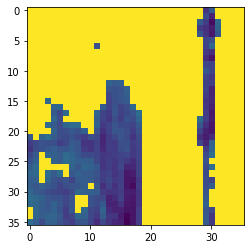

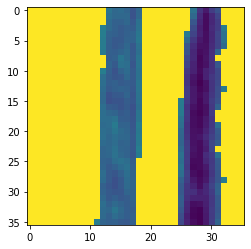

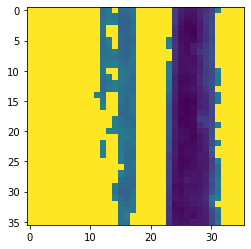

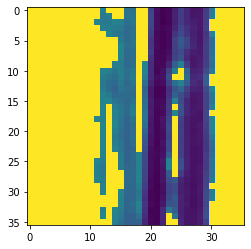

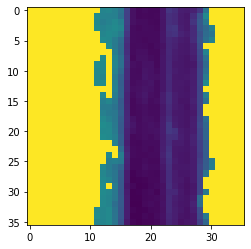

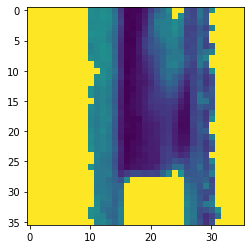

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 8.tif
[array([-1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
6


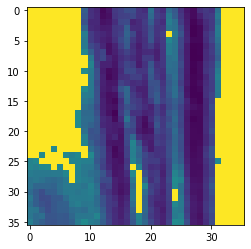

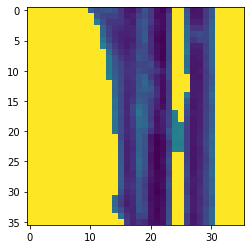

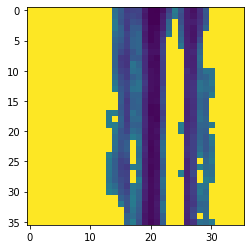

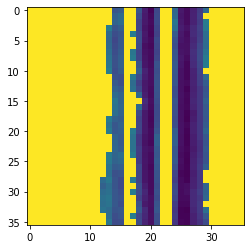

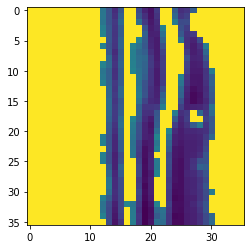

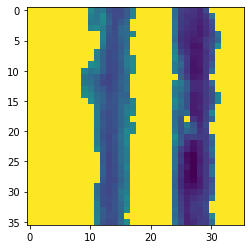

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 9.tif
[array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1])]
5


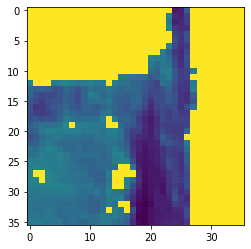

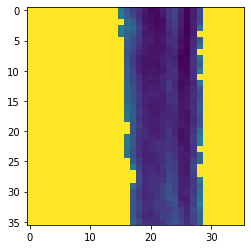

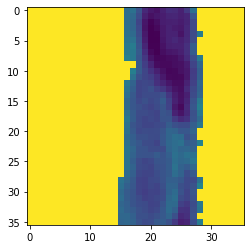

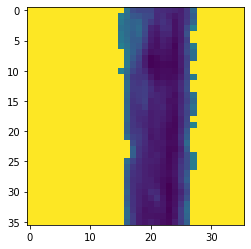

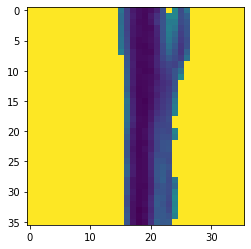

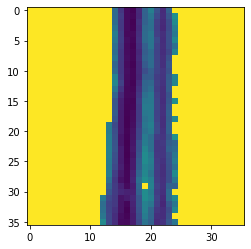

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 2.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


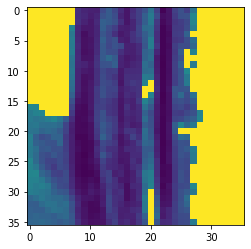

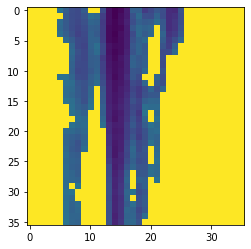

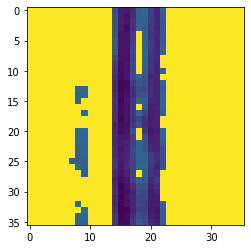

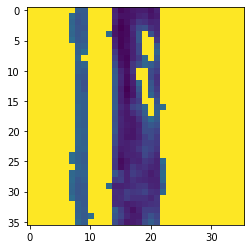

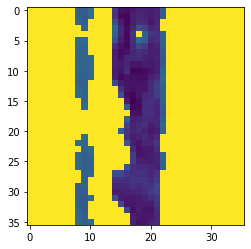

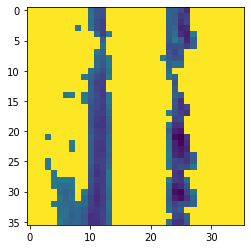

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 3.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


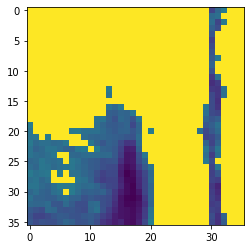

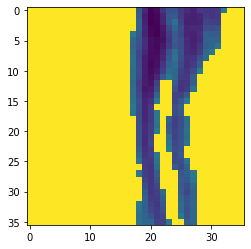

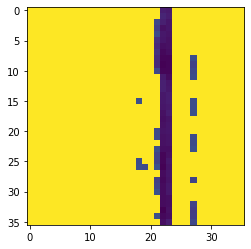

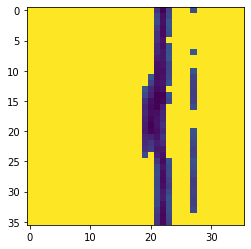

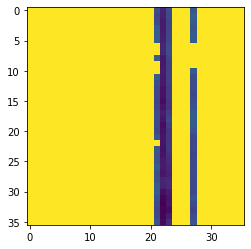

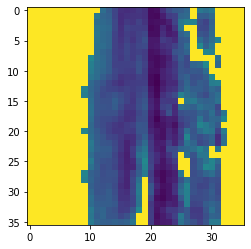

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 4.tif
[array([-1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
5


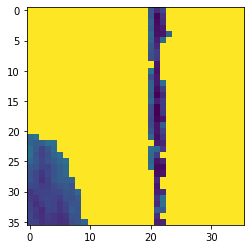

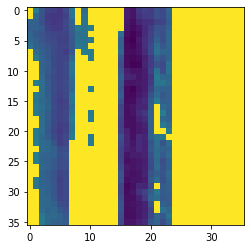

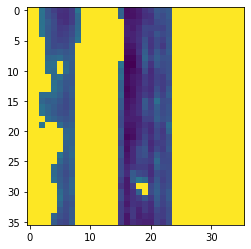

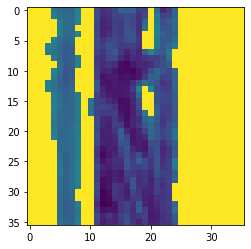

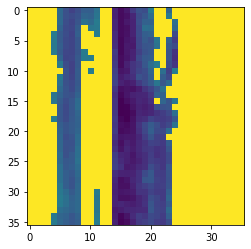

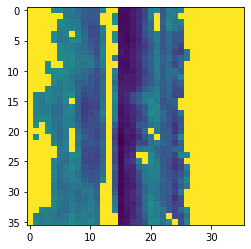

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 5.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


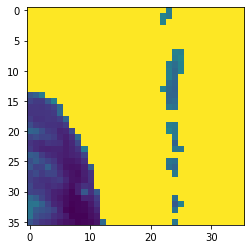

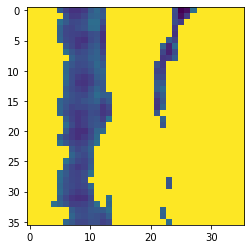

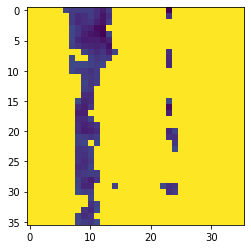

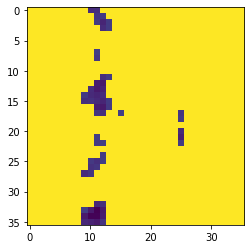

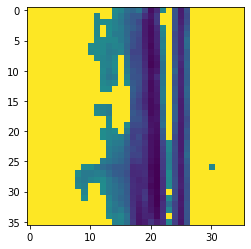

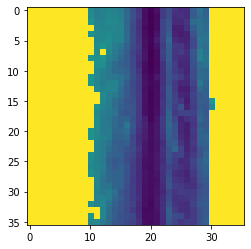

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 7.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


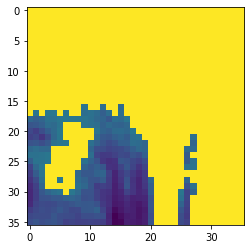

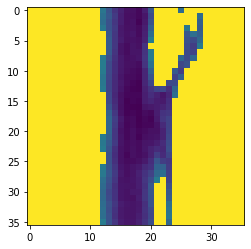

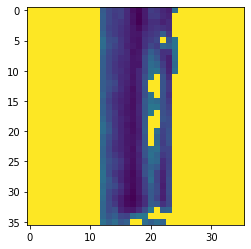

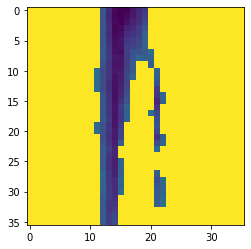

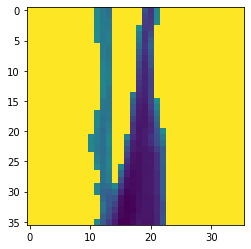

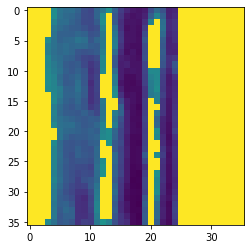

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 6.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


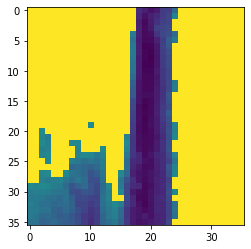

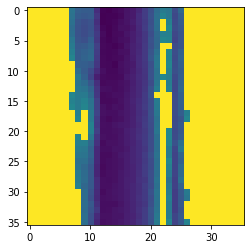

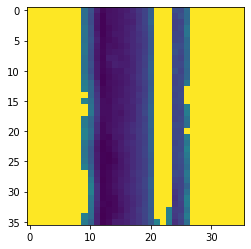

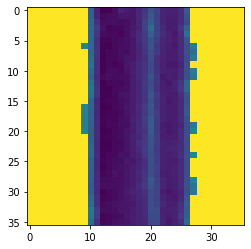

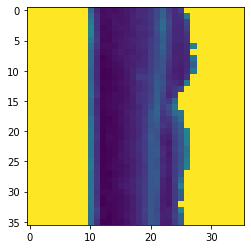

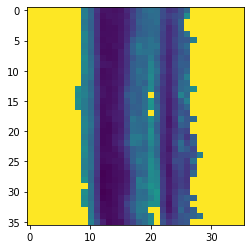

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 10.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
TRAIN scarti
BUONI : 6
Falsi buoni su scarti totali: 0.6666666666666666


In [149]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = pathScarti
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    train_images[train_images>=color_max]=1.

    plt.imshow(train_images[1],interpolation='nearest')
    plt.show()
    plt.imshow(train_images[4],interpolation='nearest')
    plt.show()
    plt.imshow(train_images[6],interpolation='nearest')
    plt.show()
    plt.imshow(train_images[10],interpolation='nearest')
    plt.show()
    plt.imshow(train_images[12],interpolation='nearest')
    plt.show()
    plt.imshow(train_images[16],interpolation='nearest')
    plt.show()
    
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
    print(img_path)
        
    print(res)
    print(scarto)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

In [150]:
temp = pathScartiVal
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = pathScarti
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    train_images[train_images>=color_max]=1.


    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
    print(img_path)
        
    print(res)
    print(scarto)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 8.tif
[array([-1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
6
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 9.tif
[array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1])]
5
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 10.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
TRAIN scarti
BUONI : 1
Falsi buoni su scarti totali: 0.3333333333333333


In [151]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


temp = pathBuoniVal
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    train_images[train_images>=color_max]=1.


    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto >= threshold:
        i +=1
    #print(img_path)
        
    #print(res)
    print(scarto)
print('Buoni validation')
print('Scarti : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

0
0
0
4
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
Buoni validation
Scarti : 11
Falsi buoni su scarti totali: 0.13924050632911392


[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


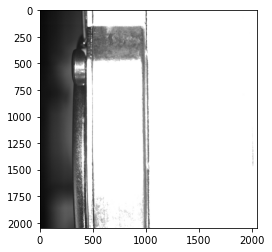

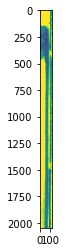

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830741.tif
[array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

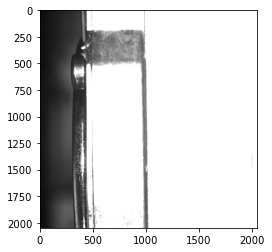

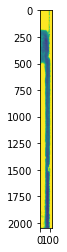

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151665.tif
[array([ 1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


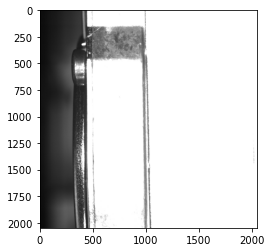

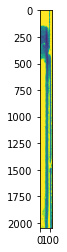

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151658.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


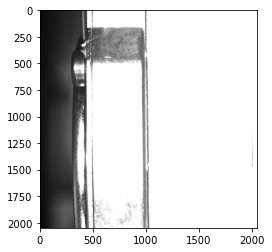

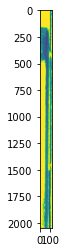

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830747.tif
[array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


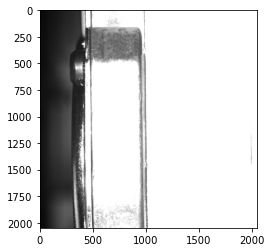

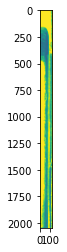

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114874942046.tif
[array([-1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1])]
5
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


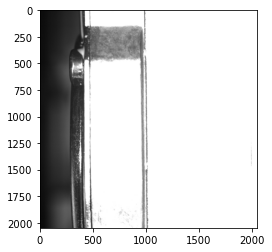

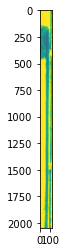

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830800.tif
[array([-1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


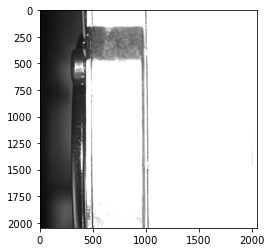

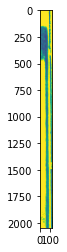

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830815.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1])]
6


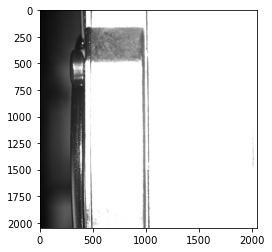

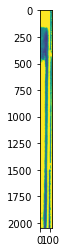

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830801.tif
[array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
2
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

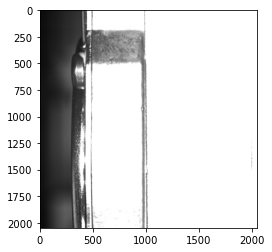

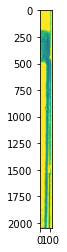

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151703.tif
[array([ 1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


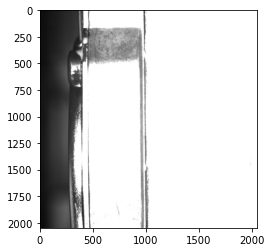

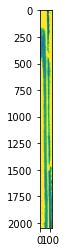

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152425.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1])]
4


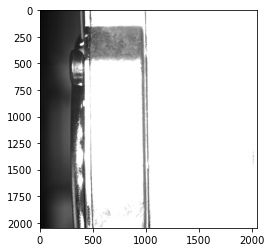

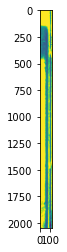

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152357.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


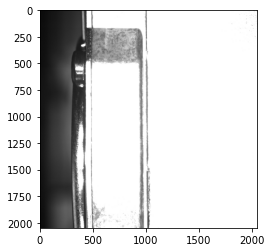

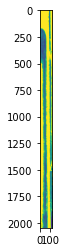

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993021.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


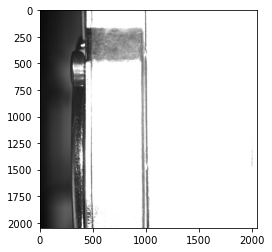

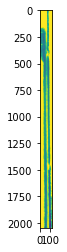

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152293.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

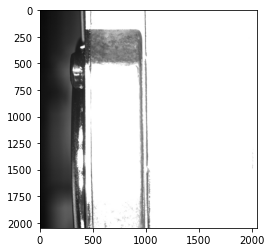

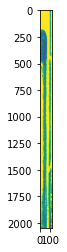

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993022.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1])]
2
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

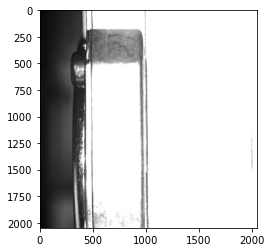

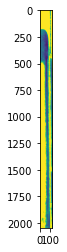

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114874942586.tif
[array([ 1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
2
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

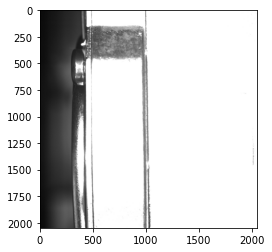

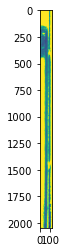

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151789.tif
[array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


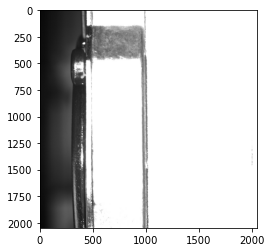

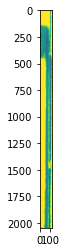

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151819.tif
[array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


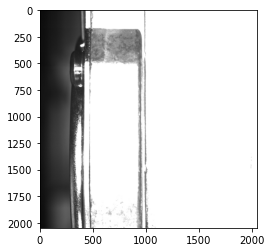

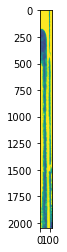

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993018.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

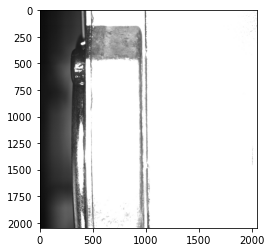

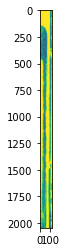

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114891012897.tif
[array([ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


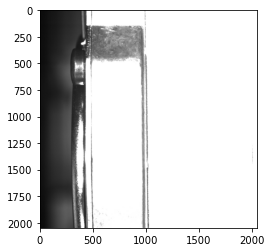

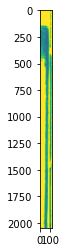

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151751.tif
[array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


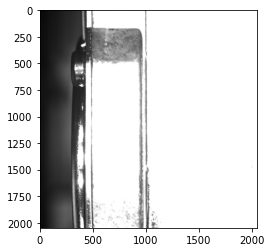

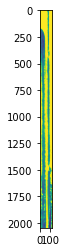

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993017.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


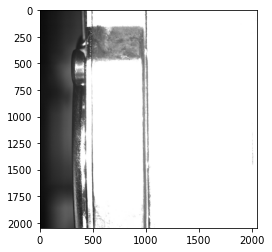

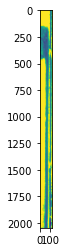

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152299.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1])]
2
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


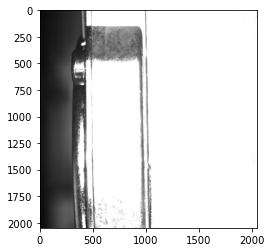

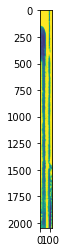

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993016.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


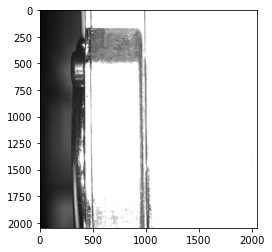

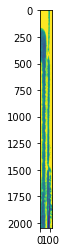

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114891031536.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1])]
2
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


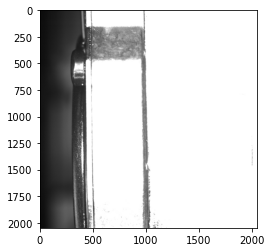

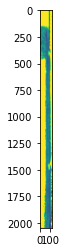

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151794.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

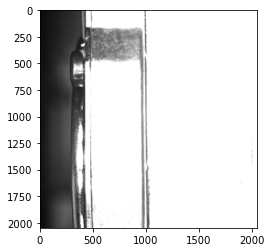

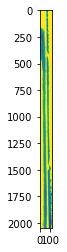

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152261.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

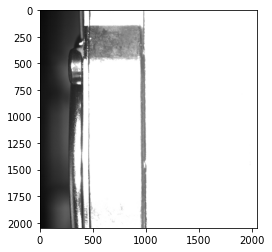

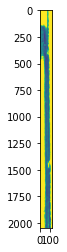

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152164.tif
[array([ 1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


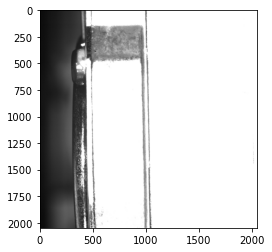

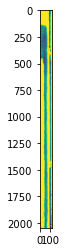

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/57014892691138.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

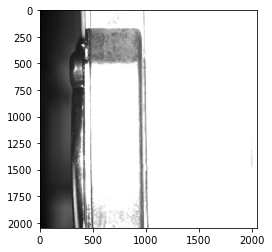

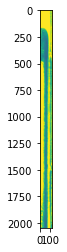

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114874941966.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

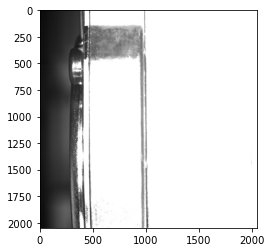

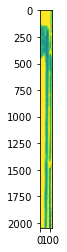

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152217.tif
[array([ 1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


In [152]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto >= threshold:
        i +=1
        plt.imshow(img)
        plt.show()
        plt.imshow(temp)
        plt.show()
        print(img_path)
        
    print(res)
    print(scarto)


In [153]:
print(len(test_path))

437


In [154]:
print('TRAIN Buoni')
print('Scarti : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

TRAIN Buoni
Scarti : 30
Falsi buoni su scarti totali: 0.06864988558352403
